# Inferencia Bayesiana Entrega 1: Maitas Moran LU 806/19

## Guia 1 - Ejercicio 9
El jugador Montiel convirtio los 12 penales que pateo al dia de la fecha en su carrera profesional

a) Usando un prior beta de la probabilidad que tiene Montiel de convertir un penal, es decir $\theta \sim \Beta(alpha, beta)$ encontrar la distribución posterior para $\theta$ y graficarla (definir a gusto los parámetros alpha y beta de la distribución).

b) ¿Cuál es la probabilidad de que convierta el penal número 13? ¿Cómo se compara con la
estimación frecuentista?

c) ¿Qué supuestos estamos haciendo sobre el proceso que generó los datos?

d) Haciendo simulaciones, crear un histograma de la distribución predicha de penales convertidos
en los próximos 10 penales que ejecute Montiel (posterior predictive distribution).

e) Estimar la probabilidad de que Montiel meta al menos 8 de los próximos 10 penales que patee.

Para esta Guia, voy a usar 2 Priors diferentes para ver que diferencias hay entre uno y el otro y como cambia las predicciones y los resultados.

- El primer Prior "Naive" Usamos como Prior $\Beta(13, 4)$ porque nos parece una distribucion que modela bien la probabilidad de que un jugador convierta un penal en base a la intuicion de saber que es mas probable que un penal termine en gol contrario a que no lo haga

- El segundo Prior va a ser una distribucion Beta en base a los datos historicos de penales de los 1599 jugadores registrados en las ligas europeas (LaLiga, Bundesliga, Serie A y Premier League) scrapeados de la pagina https://www.transfermarkt.com

### Setup

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import beta
from scipy.optimize import curve_fit
from scipy import integrate
from scipy import special as scipy_special

np.random.seed(42)

In [161]:
#Scrapeamos manualmente la base de trasnfermarkt para obtener la info
df_europe = pd.read_csv('players_penalties.csv')

print('Number of players in the dataset:', len(df_europe))
df_europe

Number of players in the dataset: 1559


,Name,Goals,Misses
0,ScottTwine,1,1
1,JuniorAjayi,0,0
2,BeñatTurrientes,0,0
3,AndrewMoran,0,1
4,ChrisRamos,0,0
...,...,...,...
1554,Juanmi,0,0
1555,IñigoRuiz de Galarreta,0,0
1556,CédricBakambu,17,1
1557,AbdoulayeDoucouré,1,0


In [162]:
# Para la simplicidad del analisis vamos a filtrar todos los jugadores con menos de 10 penales pateados.
# aunque estaria bueno ver que tanto empeora en el resultado final

df_europe = df_europe[(df_europe["Goals"] + df_europe["Misses"]) > 10]
df_europe['GoalRatio'] = df_europe['Goals'] / (df_europe['Goals'] + df_europe['Misses'])
df_europe

/tmp/ipykernel_1470573/3358776130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_europe['GoalRatio'] = df_europe['Goals'] / (df_europe['Goals'] + df_europe['Misses'])


,Name,Goals,Misses,GoalRatio
5,ÁlvaroMorata,14,4,0.777778
16,Jordan,10,3,0.769231
17,NikolaVlašić,9,5,0.642857
18,JamesMilner,30,5,0.857143
20,RomanYaremchuk,6,5,0.545455
...,...,...,...,...
1546,NealMaupay,12,3,0.800000
1550,LukeBerry,9,4,0.692308
1551,AntoineGriezmann,24,13,0.648649
1552,HakanÇalhanoğlu,41,4,0.911111


### a) Usando un prior beta de la probabilidad que tiene Montiel de convertir un penal, es decir $\theta \sim \Beta(alpha, beta)$ encontrar la distribución posterior para $\theta$ y graficarla (definir a gusto los parámetros alpha y beta de la distribución).


Para los 2 prior queremos encontrar la distribucion posterior para $\theta$

Primero calculamos la Likehood de ver los datos de montiel asumiendo que cada penal se comporta como un experimento de bernoulli con probabilidad $\theta$, es decir que cada penal tiene la misma probabilidad de terminar en gol y que es independiente del penal anterior (esto es un modelo simplista ya que implica que no depende del arquero, del contexto del partido, de lesiones de jugadores, etc)

- $Y \sim Bin(n, \theta)$
- $\theta \sim  \Beta(\alpha_{0}, \beta_{0})$

- $L(\theta | datosMontiel) = P( Y = k | \theta) = \binom{n}{k}\theta^{k}(1-\theta)^{n-k}=\theta^{12}$
- $Prior(\theta) = \theta^{\alpha_{0} - 1} \cdot (1 - \theta)^{\beta_{0} - 1}$ 



Podemos calcular la *Post* para cada *Prior* como:

- $Post(\theta | datosMontiel) \propto  L(\theta | datosMontiel) \cdot P(\theta)$

- $Post(\theta | datosMontiel) \propto \theta^{12} \cdot \theta^{\alpha_{0} - 1} \cdot (1 - \theta)^{\beta_{0} - 1}$

- $Post(\theta | datosMontiel) \propto \theta^{\alpha_{0} + 11} \cdot (1 - \theta)^{\beta_{0} - 1}$

- $Post(\theta | datosMontiel) \sim Beta(\alpha_{0} + 12, \beta_{0}) $



In [163]:
prior_naive_alpha = 13
prior_naive_beta = 4


In [164]:
# generamos numericamente 10000 samples de la distribucion beta de prior
prior_naive_samples = np.random.beta(prior_naive_alpha, prior_naive_beta, 10000) 
x = np.linspace(0, 1, 30)
y_naive = beta.pdf(x, prior_naive_alpha, prior_naive_beta)

In [165]:
#Estimamos alpha y beta en base a la distribucion de GoalRatio del dataset de jugaradores europeos
def estimate_alpha_beta(x):
    mean_x = np.mean(x)
    var_x = np.var(x)
    alpha_est = mean_x * (mean_x * (1 - mean_x) / var_x - 1)
    beta_est = (1 - mean_x) * (mean_x * (1 - mean_x) / var_x - 1)
    return alpha_est, beta_est

prior_players_alpha, prior_players_beta = estimate_alpha_beta(df_europe['GoalRatio'])

y_players = beta.pdf(x, prior_players_alpha, prior_players_beta)

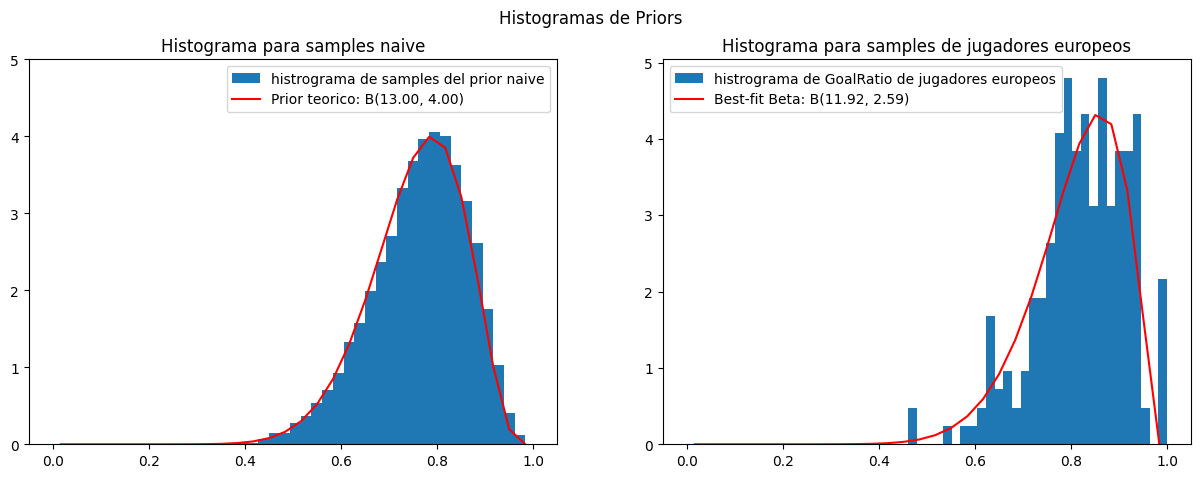

In [177]:
bins_n=30

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogramas de Priors')

ax[0].plot()
ax[0].set_title('Histograma para samples naive')
ax[0].hist(prior_naive_samples, bins=bins_n, density=True, label='histrograma de samples del prior naive')
ax[0].plot(x, y_naive, 'r-', label='Prior teorico: B({:.2f}, {:.2f})'.format(prior_naive_alpha, prior_naive_beta))
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 5)
ax[0].legend()

ax[1].plot()
ax[1].set_title('Histograma para samples de jugadores europeos')
ax[1].hist(df_europe['GoalRatio'], bins=bins_n, density=True, label='histrograma de GoalRatio de jugadores europeos')
ax[1].plot(x, y_players, 'r-', label='Best-fit Beta: B({:.2f}, {:.2f})'.format(prior_players_alpha, prior_players_beta))
ax[1].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 5)
ax[1].legend()

plt.show()

In [167]:
y_naive

array([0.00000000e+00, 1.85197664e-14, 6.80162449e-11, 7.88018678e-09,
       2.21157327e-07, 2.84731285e-06, 2.23439486e-05, 1.24338589e-04,
       5.36907090e-04, 1.90616948e-03, 5.78658336e-03, 1.54415591e-02,
       3.69558442e-02, 8.05084724e-02, 1.61425305e-01, 3.00358984e-01,
       5.21712521e-01, 8.49360785e-01, 1.29900113e+00, 1.86725926e+00,
       2.51912018e+00, 3.17733428e+00, 3.71986947e+00, 3.99345867e+00,
       3.85129091e+00, 3.21826268e+00, 2.17372876e+00, 1.01301661e+00,
       1.95910533e-01, 0.00000000e+00])

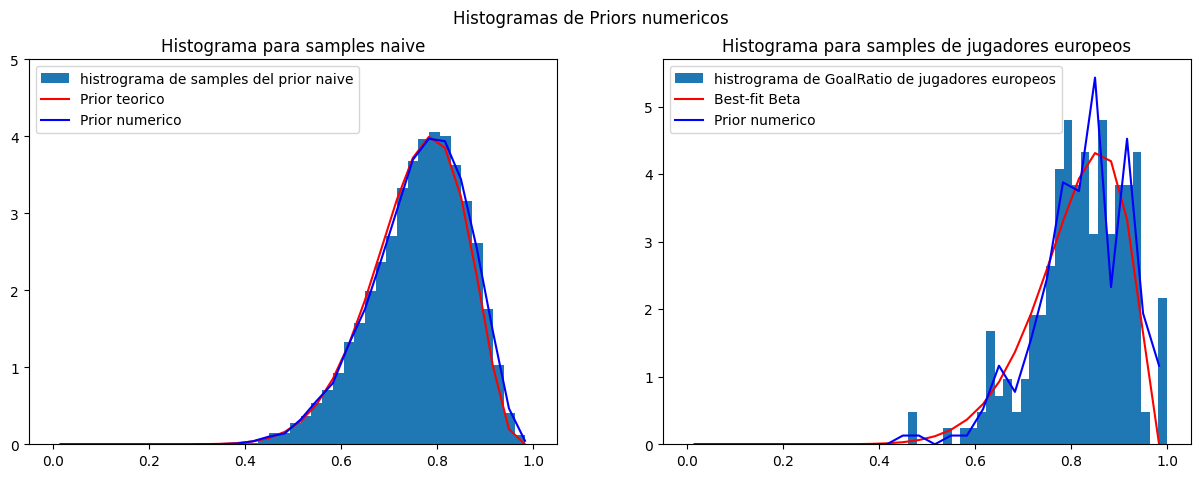

In [178]:
# Ahora vamos a obtener numericamente la funcion del prior a partir del histograma de los samples y la vamos a escalar para que sea una PDF
y_prior_naive, x_bins = np.histogram(prior_naive_samples, bins=bins_n, range=(0, 1))
y_prior_naive = y_prior_naive / np.sum(y_prior_naive * (x_bins[1] - x_bins[0])) # escalamos para que sea PDF dividiendo por la "integral"
x = x_bins[:-1] + (x[1] - x[0]) / 2

y_prior_player, _ = np.histogram(df_europe['GoalRatio'], bins=bins_n, range=(0, 1))
y_prior_players = y_prior_player / np.sum(y_prior_player * (x_bins[1] - x_bins[0]))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogramas de Priors numericos')

ax[0].plot()
ax[0].set_title('Histograma para samples naive')
ax[0].hist(prior_naive_samples, bins=bins_n, density=True, label='histrograma de samples del prior naive')
ax[0].plot(x, y_naive, 'r-', label='Prior teorico')
ax[0].plot(x, y_prior_naive, 'b-', label='Prior numerico')
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 5)
ax[0].legend()

ax[1].plot()
ax[1].set_title('Histograma para samples de jugadores europeos')
ax[1].hist(df_europe['GoalRatio'], bins=bins_n, density=True, label='histrograma de GoalRatio de jugadores europeos')
ax[1].plot(x, y_players, 'r-', label='Best-fit Beta')
ax[1].plot(x, y_prior_players, 'b-', label='Prior numerico')
ax[1].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 5)
ax[1].legend()

plt.show()

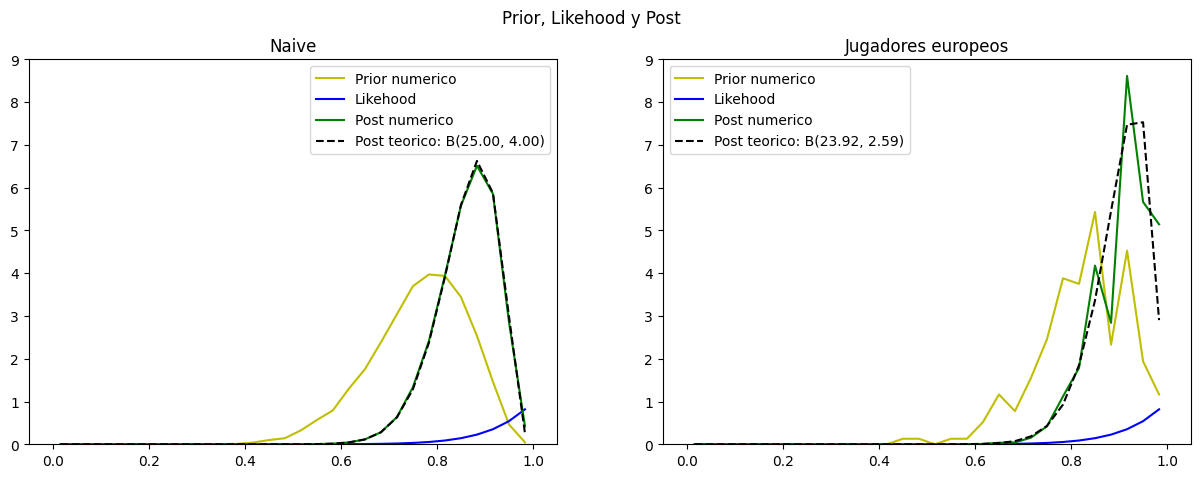

In [180]:
# ahora ya contamos con una discretizacion de la PDF del prior vamos a calcular la Likehood de la binomial y su posterior normalizada

y_likehood = x**12

y_post_naive = y_likehood * y_prior_naive
y_post_naive = y_post_naive / np.sum(y_post_naive * (x[1] - x[0]))

y_post_players = y_likehood * y_prior_players
y_post_players = y_post_players / np.sum(y_post_players * (x[1] - x[0]))


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Prior, Likehood y Post')

ax[0].set_title('Naive')
ax[0].plot(x, y_prior_naive, 'y-', label='Prior numerico')
ax[0].plot(x, y_likehood, 'b-', label='Likehood')
ax[0].plot(x, y_post_naive, 'g', label='Post numerico')
ax[0].plot(x, beta.pdf(x, prior_naive_alpha + 12, prior_naive_beta), 'black', linestyle='--', label='Post teorico: B({:.2f}, {:.2f})'.format(prior_naive_alpha + 12, prior_naive_beta))
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 9)
ax[0].legend()

ax[1].set_title('Jugadores europeos')
ax[1].plot(x, y_prior_players, 'y-', label='Prior numerico')
ax[1].plot(x, y_likehood, 'b-', label='Likehood')
ax[1].plot(x, y_post_players, 'g', label='Post numerico')
ax[1].plot(x, beta.pdf(x, prior_players_alpha + 12, prior_players_beta), 'black', linestyle='--', label='Post teorico: B({:.2f}, {:.2f})'.format(prior_players_alpha + 12, prior_players_beta))
ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(0, 9)
ax[1].legend()

plt.show()

### b) ¿Cuál es la probabilidad de que convierta el penal número 13? ¿Cómo se compara con la estimación frecuentista?

In [ ]:
from scipy.stats import rv_discrete

# Funcion para generar samples a partir de una distribucion
def sample_from_pdf(n, x_values, y_values):
    pdf = rv_discrete(name='my_pdf', values=(x_values, y_values))
    return pdf.rvs(size=n)

[Naive] Promedio 0.8621220000000002
[Naive] Esperanza Teorica 0.8620689655172413
[Players] Promedio 0.9067529999999999
[Players] Esperanza Teorica 0.90239164871472


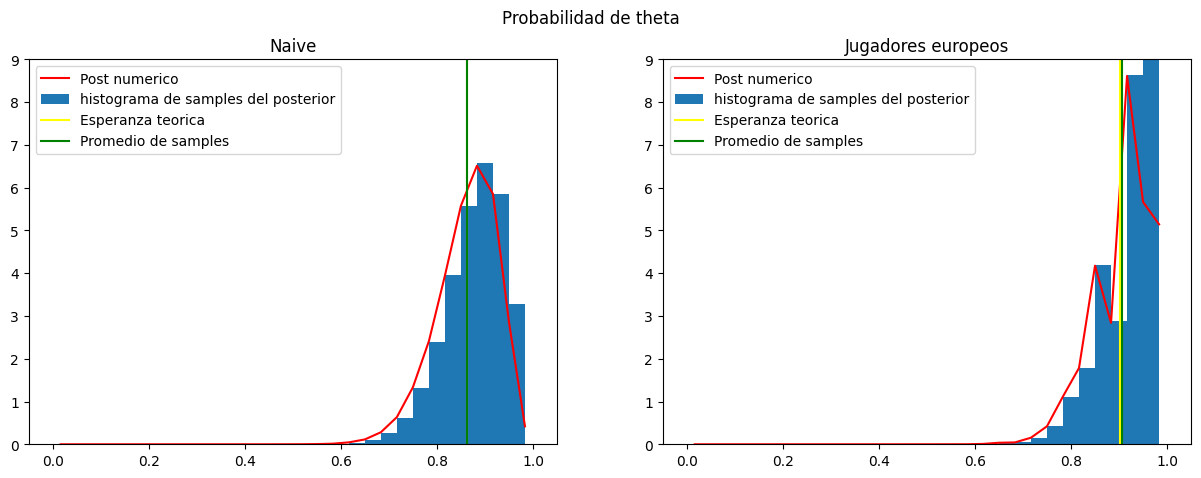

In [183]:
samples_naive = sample_from_pdf(100000, x, y_post_naive/np.sum(y_post_naive)) # normalizamos y_post para que sume 1
samples_players = sample_from_pdf(100000, x, y_post_players/np.sum(y_post_players)) # normalizamos y_post para que sume 1

naive_mean = np.mean(samples_naive)
naive_teorical_mean = (prior_naive_alpha + 12) / (prior_naive_alpha + 12 + prior_naive_beta)

players_mean = np.mean(samples_players)
players_teorical_mean = (prior_players_alpha + 12) / (prior_players_alpha + 12 + prior_players_beta)

print("[Naive] Promedio", naive_mean)
print("[Naive] Esperanza Teorica", naive_teorical_mean)     # E = alpha / alpha + beta 

print("[Players] Promedio", players_mean)
print("[Players] Esperanza Teorica", players_teorical_mean)     # E = alpha / alpha + beta 


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Probabilidad de theta')

ax[0].set_title('Naive')
ax[0].plot(x, y_post_naive, 'r', label='Post numerico')
ax[0].hist(samples_naive, bins=x, density=True, label='histograma de samples del posterior')
ax[0].axvline(naive_teorical_mean, color ="yellow", label = "Esperanza teorica")
ax[0].axvline(naive_mean, color = "green", linestyle = "-", label = "Promedio de samples")
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 9)
ax[0].legend()

ax[1].set_title('Jugadores europeos')
ax[1].plot(x, y_post_players, 'r', label='Post numerico')
ax[1].hist(samples_players, bins=x, density=True, label='histograma de samples del posterior')
ax[1].axvline(players_teorical_mean, color ="yellow", label = "Esperanza teorica")
ax[1].axvline(players_mean, color = "green", linestyle = "-", label = "Promedio de samples")
ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(0, 9)
ax[1].legend()

plt.show()

- La probabilidad de que convierta el siguiente penal es de 86.21% que fue lo calculado con las simulaciones para la posterior naive.
- Para la posterior basad en los jugadores europeos aumenta a un 90.68%
- En cambio, si lo hicieramos desde un aproach frecuentista en base a los datos el porcentaje seria 12/12 = 100% de probabilidad de convertir el gol.

### c)  ¿Qué supuestos estamos haciendo sobre el proceso que generó los datos?

- Estamos asumiendo que la probabilidad de convertir penales son independientes entre si al modelarlo como un experimento de Bernoulli
- Estamos asumiendo que la probabilidad de convertir penales es siempre la misma para un jugador y que muchos factores como la habilidad del arquero, el estado fisico del jugador, el contexto del partido no influyen en el resultado

### d)  Haciendo simulaciones, crear un histograma de la distribución predicha de penales convertidos en los próximos 10 penales que ejecute Montiel (posterior predictive distribution).

Promedio: 8.77675


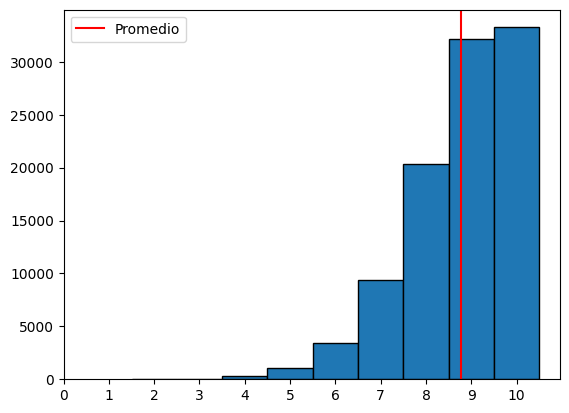

In [ ]:
samples_naive = sample_from_pdf(100000, x, y_post_naive/np.sum(y_post_naive)) # normalizamos y_post para que sume 1

# Generamos aleatoriamente cuantos goles metió de los 10 tiros para cada sample de theta.
goals_predicted = np.vectorize(lambda x: np.random.binomial(10, x))(samples_naive)

naive_mean= np.mean(goals_predicted)
print("Promedio:", naive_mean)

fig, ax = plt.subplots(1)
d = np.diff(np.unique(goals_predicted)).min()
left_of_first_bin = goals_predicted.min() - float(d)/2
right_of_last_bin = goals_predicted.max() + float(d)/2
plt.hist(goals_predicted, np.arange(left_of_first_bin, right_of_last_bin + d, d), edgecolor='black')
ax.set_xticks([i for i in range(11)])
ax.axvline(naive_mean, color = "red", label = "Promedio")
ax.legend()
plt.show()

### e) Estimar la probabilidad de que Montiel meta al menos 8 de los próximos 10 penales que patee.

In [ ]:
# contamos la cantidad de samples que tienen al menos 8 goles y dividimos por la cantidad total
len(np.where(goals_predicted >= 8)[0])/len(goals_predicted)

0.85741

# a

In [ ]:
#Scrapeamos manualmente la base de trasnfermarkt para obtener la info
df_europe = pd.read_csv('players_penalties.csv')

print('Number of players in the dataset:', len(df_europe))
df_europe

Number of players in the dataset: 1559


,Name,Goals,Misses
0,ScottTwine,1,1
1,JuniorAjayi,0,0
2,BeñatTurrientes,0,0
3,AndrewMoran,0,1
4,ChrisRamos,0,0
...,...,...,...
1554,Juanmi,0,0
1555,IñigoRuiz de Galarreta,0,0
1556,CédricBakambu,17,1
1557,AbdoulayeDoucouré,1,0


In [ ]:
# Para la simplicidad del analisis vamos a filtrar todos los jugadores con menos de 10 penales pateados.
# aunque estaria bueno ver que tanto empeora en el resultado final

df_europe = df_europe[(df_europe["Goals"] + df_europe["Misses"]) > 10]
df_europe['GoalRatio'] = df_europe['Goals'] / (df_europe['Goals'] + df_europe['Misses'])
df_europe

/tmp/ipykernel_1470573/3358776130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_europe['GoalRatio'] = df_europe['Goals'] / (df_europe['Goals'] + df_europe['Misses'])


,Name,Goals,Misses,GoalRatio
5,ÁlvaroMorata,14,4,0.777778
16,Jordan,10,3,0.769231
17,NikolaVlašić,9,5,0.642857
18,JamesMilner,30,5,0.857143
20,RomanYaremchuk,6,5,0.545455
...,...,...,...,...
1546,NealMaupay,12,3,0.800000
1550,LukeBerry,9,4,0.692308
1551,AntoineGriezmann,24,13,0.648649
1552,HakanÇalhanoğlu,41,4,0.911111


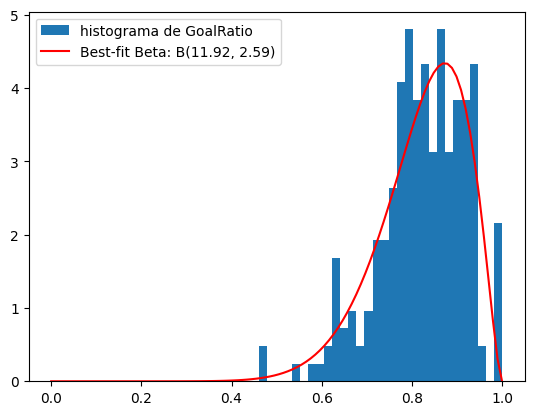

In [ ]:
def estimate_alpha_beta(x):
    mean_x = np.mean(x)
    var_x = np.var(x)
    alpha_est = mean_x * (mean_x * (1 - mean_x) / var_x - 1)
    beta_est = (1 - mean_x) * (mean_x * (1 - mean_x) / var_x - 1)
    return alpha_est, beta_est

prior_players_alpha, prior_players_beta = estimate_alpha_beta(df_europe['GoalRatio'])

x = np.linspace(0, 1, 100)
y = beta.pdf(x, prior_players_alpha, prior_players_beta)
plt.hist(df_europe['GoalRatio'], label='histograma de GoalRatio', bins=30, density=True)
plt.plot(x, y, 'r-', label='Best-fit Beta: B({:.2f}, {:.2f})'.format(prior_players_alpha, prior_players_beta))
plt.legend()
plt.xlim(-0.05, 1.05)
plt.show()

Vamos a buscar la probabilidad de que Montiel convierta el penal numero 13.

Promedio 0.9263623036547501
Esperanza 0.9285714285714286


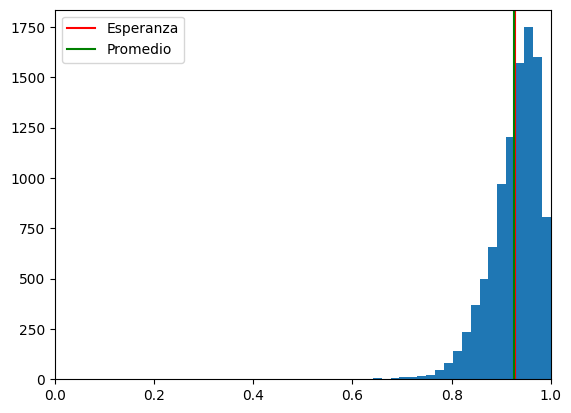

In [ ]:
# Generamos unos titas randoms.
# A partir de esos titas simulamos la cantidad de goles hechos.
# Estos goles los guardamos en "tiros".
samples_naive = np.array([])
for i in range(1,10000):
    tita = np.random.beta(25, 2)
    samples_naive = np.append(samples_naive, tita)


# Calculamos la mediana y el promedio de "tiros" 
naive_mean= np.mean(samples_naive)
print("Promedio", naive_mean)
print("Esperanza", 13 / (13+1))     # E = alpha / alpha + beta 
fig, ax = plt.subplots(1)
ax.hist(samples_naive, bins = 20)
ax.set_xlim(0,1)
ax.axvline(13 / (13+1), color ="red", label = "Esperanza")
ax.axvline(naive_mean, color = "green", linestyle = "-", label = "Promedio")
ax.legend()
plt.show()

- Segun los Bayesianos, tenemos un 92.6% de probabilidades de ver a Montiel meter el 13vo tiro.

- Mientras que los frecuentistas dirian que es el 100%.

### e) Estimar la probabilidad de que Montiel meta al menos 8 de los próximos 10 penales que patee.

Teniendo el Histograma anterior, podriamos simplemente sumar los casos en que Montiel haya metido 8, 9 y 10 penales y dividirlos por la cantidad total de intentos. 

In [ ]:
# Filtramos los casos en que Montiel haya metido >= 8 goles
tiros_predichos_filtrados = [tiro for tiro in goals_predicted if tiro >= 8]

# Calculamos el promedio frecuentista de que meta >= 8 goles.
len(tiros_predichos_filtrados) / len(goals_predicted)

0.85741